In [1]:
import matplotlib.pyplot as plt
import random
import numpy as np
import time
from copy import deepcopy
from sklearn.datasets import make_classification as ds
from sklearn.model_selection import train_test_split as split

In [5]:
class logRegGD:
    def __init__(self,error, run, pltLength):
        self.weights_original = None # original copy to reference back to
        # generated test/train split
        self.xTrain = None
        self.yTrain = None
        self.xTest = None
        self.yTest = None
        self.weights = None # weights
        self.maxRunTime = run # cut off point for 
        self.initialTime = None # starting time
        self.time = None # time taken for a method run
        self.error = error # allowed error/epsilon
        self.grad = None # current gradient
        self.lamb = None # current step size
        self.gr_list = None # list of values of norms of gradient
        self.norm = None # current norm of gradient 
        self.theta = None # theta value used in Adpative
        self.preds = None # predicted classifications
        self.classi = None # proportion of correct classifications
        # Plots for different methods
        self.vanPlt = None
        self.AdapPlt = None
        self.LSPlt = None
        self.BazPlt = None
        self.Max = pltLength # maximum value for x axis in plt
    #-------------------------------------------------------------------------------------
    
    def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function
    
    def normalise(self, X): # normalises the input data to values between 0 and 1
        mins = np.min(X, axis = 0) 
        maxs = np.max(X, axis = 0) 
        rng = maxs - mins 
        norm_X = 1 - ((maxs - X)/rng) 
        return norm_X 
    
    def generate(self, samples, test_size): # generates sample data 
        sample_data = ds(n_samples=samples)
        augmented_data = np.concatenate((np.array([[1]*len(sample_data[0])]).T,\
                                         self.normalise(sample_data[0])), axis =1)
        entire_set = list(sample_data)
        entire_set[0] = augmented_data
        self.xTrain, self.xTest, self.yTrain, self.yTest = split( entire_set[0], entire_set[1], \
                                                                 test_size = test_size, random_state= 13)
        self.weights_original = np.random.rand(len(self.xTrain[0]),1)
    
    # in all methods used, we don't need f for any of them, just gradient(f)
    def cost_func(self, W): # function f: the inverse of the log likelihood function, modelling the probability of the data xTrain and xTest
        sig = self.sigmoid(W, self.xTrain)
        y = np.squeeze(self.yTrain)
        step1 = y * np.log(sig)
        step2 = (1 - y) * np.log(1 - sig) 
        final = -step1 - step2 
        return np.mean(final)
    
    def log_gradient(self, W): # the gradient function of f, simply (h(w) - y) * x
        sig = self.sigmoid(W, self.xTrain)
        inner_expr = np.squeeze(sig) - np.squeeze(self.yTrain.reshape(self.xTrain.shape[0],-1))
        return np.dot(inner_expr.T, self.xTrain )
    
    def GD(self): # Step size calculator - w_1 = w_0 - lam* gradient(w)
        self.weights = np.squeeze(self.weights) - self.lamb * self.log_gradient(self.weights)
    
    def calc_norm(self): # to calculate the norm of a gradient of a weight vector
        self.norm = np.linalg.norm(self.log_gradient(self.weights))
    
    def predict(self, beta, X):
        predP = self.sigmoid(beta, X) # predict classification probability 
        predVal = np.where(predP >= 0.5 , 1 , 0) # allocate most likely classifier
        self.preds = np.squeeze(predVal)
    
    
    #-------------------------------------------------------------------------------------------
    
    def Vanilla(self):
        self.initialTime = time.time() # start the clock
        self.weights = deepcopy(self.weights_original) # make a copy of the weights
        self.gr_list = [] # create a list for recording norms of gradients
        self.lamb = 1/np.max( np.linalg.svd( self.xTrain @ self.xTrain.T )[1] ) # make step size using SVD
        count = 1
        self.calc_norm() # calculate norm of the gradient of the weights
        while self.norm > self.error: # start loop
            self.GD() # Step in steepest negative direction
            self.calc_norm()
            self.gr_list.append(self.norm)
            count += 1
            if time.time() - self.initialTime > self.maxRunTime: # check within time limit
                break
        self.time = round(time.time() - self.initialTime, 2) # stop the clock
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print(' \n Vanilla Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0,  min(len(self.gr_list), self.Max ) , 'g', self.vanPlt, 'Vanilla {} sec'.format(self.time))
        self.PrintResults()
    
    def Adaptive(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.lamb = random.random()+1e-12
        self.theta = float(random.getrandbits(128))
        oldW = deepcopy(self.weights)
        self.GD()
        self.calc_norm()
        while self.norm > self.error:
            oldLam = deepcopy(self.lamb)
            min1 = np.sqrt(1 + self.theta)*self.lamb
            min2 = ( np.linalg.norm( self.weights - oldW ) ) \
            / ( 2 * np.linalg.norm( self.log_gradient(self.weights) - self.log_gradient(oldW)) )
            self.lamb = np.min([min1,min2])
            oldW = deepcopy(self.weights)
            self.GD()
            self.theta = self.lamb/oldLam
            self.calc_norm()
            self.gr_list.append(self.norm)
            if time.time() - self.initialTime > self.maxRunTime:
                break
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Adaptive Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'y', self.AdapPlt, 'Adaptive {} sec'.format(self.time))
        self.PrintResults()
    
    def BackTrack(self):
        def normal(X): 
            return np.linalg.norm(X)
        rho = random.random()
        lam = random.randrange(1e6)
        while lam > ( normal( lam * self.grad ) / \
                     ( normal( self.log_gradient( np.squeeze(self.weights) - lam * self.grad ) - self.grad ) )  ):
            lam = rho * lam
        self.lamb = lam
                
    def LineSearch(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.calc_norm()
        self.grad = self.log_gradient(self.weights)
#         count = 1
        while self.norm > self.error:
            self.BackTrack()
            self.GD()
            self.grad = self.log_gradient(self.weights)
            self.calc_norm()
            self.gr_list.append(self.norm)
#             count +=1
            if time.time() - self.initialTime > self.maxRunTime:
                break
#         print(count)
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Line Search Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'b', self.LSPlt, 'LineSearch {} sec'.format(self.time))
        self.PrintResults()
        
    def Barzilai(self):
        self.initialTime = time.time()
        self.weights = deepcopy(self.weights_original)
        self.gr_list = []
        self.lamb = random.random()+1e-12
        oldW = deepcopy(self.weights)
        self.GD()
        self.calc_norm()
        while self.norm > self.error:
            oldLam = deepcopy(self.lamb)
            self.lamb = np.dot( np.squeeze(self.weights - oldW), \
                               self.log_gradient(self.weights) - self.log_gradient(oldW) ) \
                        / np.linalg.norm( self.log_gradient(self.weights) - self.log_gradient(oldW) )**2
            oldX = deepcopy(self.weights)
            self.GD()
            self.calc_norm()
            self.gr_list.append( self.norm)
            if time.time() - self.initialTime > self.maxRunTime:
                break
        self.time = round(time.time() - self.initialTime, 2)
        self.predict(self.weights, self.xTest)
        self.classi = sum( self.preds == self.yTest )/len(self.xTest)
        print('\n Barzilai-Borwein Gradient Descent:')
        print('_____________________________________________')
#         if len(self.gr_list) > self.Max:
#             self.Max = deepcopy(len(self.gr_list))
        self.SetPlots(0, min(len(self.gr_list), self.Max ) , 'r', self.BazPlt, 'Barzilai {} sec'.format(self.time))
        self.PrintResults()
    
    
    def SetPlots(self, Min, Max, colour, name, label):
        name = plt.plot( range( Min, Max ) , self.gr_list[Min:Max] , c = colour , label = label)
    def PrintPlots(self):
        self.vanPlt
        self.AdapPlt
        self.LSPlt
        self.BazPlt
        plt.yscale('log')
        plt.xlabel('Iteration')
        plt.legend(loc='best')
        plt.title(label = 'Norm of Gradient') # in domain [{}, {}]'.format(0, 600 ) )
        plt.show()
    def PrintResults(self):
        print('At final iteration k =', len(self.gr_list), ':')
        print('weights vector is:', self.weights)
        print('Gradient Norm is:', self.norm)
        print('Time taken:', self.time)
        print('Final Lambda value: ', self.lamb)
        print('Percentage of points correctly classified: ', self.classi*100, "%")

Ten iterations, logarithmic scale

epsilon = 0.1 , 
allowed time = 15  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 43378 :
weights vector is: [ -4.07798325   0.38985367   0.42507807  -0.63735404   1.10566704
   1.25231909  -0.65507902  -0.44131627   0.5412397  -10.58096661
   0.30438736   0.59745958  -0.98520493   0.14622675   1.7951626
  -0.21673091   8.94107181   0.85971668   2.66479709   2.83746211
  -0.46613104]
Gradient Norm is: 0.09999413705642979
Time taken: 16.62
Final Lambda value:  0.00017993342645691705
Percentage of points correctly classified:  94.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 1626 :
weights vector is: [ -4.37698356   0.43663782   0.49151747  -0.61074444   1.16265918
   1.3493653   -0.59630276  -0.40707534   0.59739078 -10.84208346
   0.33396236   0.65349723  -0.94724898   0.2313241    1.93387715
  -0.15133316   8.9615156    0.91527269   2.53522472   2.82252476
  -0.42067184]
Gradient Norm is: 0.09831473970361818
Time taken: 1.24
Final Lambda value:  0.0020628743961957083
Percentage of points correctly classified:  95.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 651 :
weights vector is: [ -4.1113709    0.39511578   0.43256703  -0.63440354   1.11193855
   1.26330163  -0.64846415  -0.43748998   0.54754922 -10.6097634
   0.30767685   0.60368875  -0.981037     0.15555858   1.81068368
  -0.209375     8.94293338   0.86600667   2.65014093   2.83558498
  -0.4609937 ]
Gradient Norm is: 0.08131520481356315
Time t

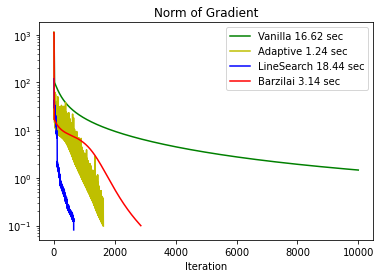

epsilon = 0.01 , 
allowed time = 30  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 128722 :
weights vector is: [ -8.10142728  -0.0479291    0.36593878   0.0650433    6.4649039
   0.91158705  -0.15044102 -13.37763222   0.92099245  -0.30576054
  -0.33881909   1.95315654   4.82672275   0.05525384  -0.90479892
  11.4867839   -1.27680227   1.54298411   1.44452853  -1.22346516
   2.02006331]
Gradient Norm is: 0.009999781720233107
Time taken: 48.27
Final Lambda value:  0.00018411172212260017
Percentage of points correctly classified:  90.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2624 :
weights vector is: [ -8.16304154  -0.03469861   0.37228609   0.07447373   6.45430093
   0.9210415   -0.14475898 -13.42818861   0.93281605  -0.29638614
  -0.32955008   1.96756838   4.84414273   0.06395045  -0.90100977
  1

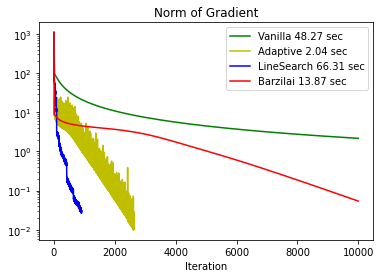

epsilon = 0.001 , 
allowed time = 45  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 65362 :
weights vector is: [-0.52322974  0.05695886 -1.97710639  2.28707834 -0.25211698  0.27870708
 -1.0364663  -0.29143806  6.38088608 -7.93511634 10.24955499  0.16387444
  1.09535807 -1.968819   -0.08811429  0.96739561 -1.03095056 -1.04563809
 -0.60112248  0.59769064  2.4802421 ]
Gradient Norm is: 0.0009999771325045136
Time taken: 24.63
Final Lambda value:  0.0001737804704894126
Percentage of points correctly classified:  87.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2951 :
weights vector is: [-0.52109162  0.05686575 -1.97782768  2.28721635 -0.25240614  0.27843514
 -1.03698915 -0.29193609  6.38097699 -7.934925   10.25102099  0.1636273
  1.09510288 -1.96936636 -0.08838975  0.96716147 -1.03133348 -1.04634966
 -0.

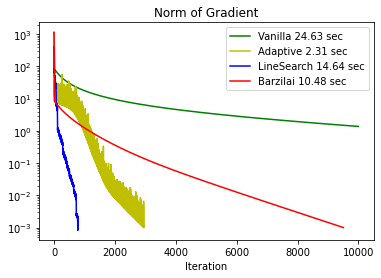

epsilon = 0.0001 , 
allowed time = 60  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 160366 :
weights vector is: [ -9.99815442  -0.37598139  -1.25384575   1.28216088   2.19997599
   1.06671414   0.7712608    1.62611698  -0.33210114  18.52245869
  -0.54853174  -0.46370982   0.70800219  -0.86901002   0.61589413
   0.14159139 -10.64026577  -0.49952935  -0.76399348   0.71282575
   6.59171068]
Gradient Norm is: 0.0017610023095903174
Time taken: 60.0
Final Lambda value:  0.00018548852577436142
Percentage of points correctly classified:  88.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 5070 :
weights vector is: [-10.00295617  -0.37571554  -1.25356486   1.28280729   2.20149706
   1.06725717   0.77220607   1.62741642  -0.33164273  18.52622505
  -0.54815814  -0.46337417   0.7087356   -0.86878345   0.61424542


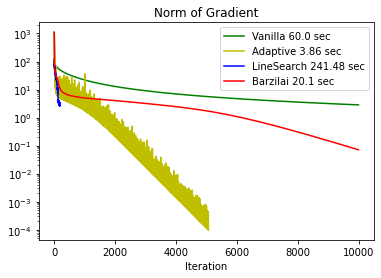

epsilon = 1e-05 , 
allowed time = 75  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 127683 :
weights vector is: [ 3.11189523 -1.12040981  0.7721643  -0.18337673  0.20675275 -5.07221537
  1.50016367  0.15097439  0.49309887  0.446634   -0.40562942 -5.77974031
  9.06149064  0.05899394 -0.57561677  0.10924765 -0.29018265 -2.21060028
  0.27042173 -0.25922289  0.53415604]
Gradient Norm is: 9.999126878170573e-06
Time taken: 47.02
Final Lambda value:  0.0001794348283855397
Percentage of points correctly classified:  84.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 3832 :
weights vector is: [ 3.11191831 -1.12041597  0.77216095 -0.1833826   0.20674985 -5.07221159
  1.50016182  0.1509704   0.49309506  0.44662765 -0.40563429 -5.77973601
  9.0615112   0.05899202 -0.57562142  0.10923953 -0.29018768 -2.21060151
  

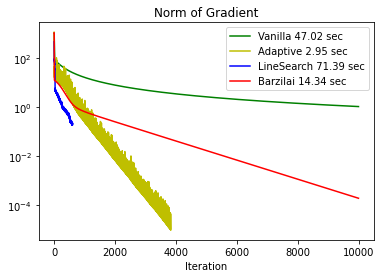

epsilon = 1e-06 , 
allowed time = 90  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 164427 :
weights vector is: [-11.5297037    0.07765708  -0.45756462   0.70340374   0.42782784
  11.95323144   0.37984481   0.92979296  -0.69498228  -1.40574659
   0.16990181  10.14922874   0.85331511  -0.07664803   0.46740462
  -0.32324966  -1.16004535   0.25733089   3.74755422  -0.44443734
  -1.95490314]
Gradient Norm is: 0.0009249406842172123
Time taken: 60.0
Final Lambda value:  0.00018343745585904333
Percentage of points correctly classified:  88.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 6767 :
weights vector is: [-11.53279911   0.07794149  -0.45726142   0.70372026   0.42820562
  11.95425882   0.38017232   0.92968568  -0.69472872  -1.40547148
   0.17009536  10.15012071   0.85374431  -0.07633318   0.46765329
 

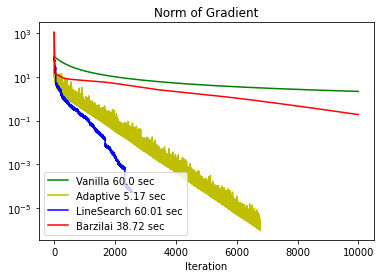

epsilon = 1e-07 , 
allowed time = 105  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 107916 :
weights vector is: [ 0.64095219 -0.36279763  8.0747324  -1.1142797   0.19843956 -0.59568196
 -0.08606125 -0.21395475  0.26626759 -0.06400461 -6.07057337 -0.69125537
 -0.13940006  0.75849315  1.32158465 -0.38116048 -1.65064995  0.58753292
  0.4860597  -0.20102251  0.58211883]
Gradient Norm is: 9.998551626077958e-08
Time taken: 39.62
Final Lambda value:  0.00019939609081105988
Percentage of points correctly classified:  89.0 %


<ipython-input-5-71fbc014ab1b>:110: RuntimeWarning: divide by zero encountered in double_scalars
  min2 = ( np.linalg.norm( self.weights - oldW ) ) \



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4097 :
weights vector is: [ 0.64095235 -0.36279766  8.07473251 -1.11427963  0.19843952 -0.59568199
 -0.08606128 -0.21395477  0.26626754 -0.06400465 -6.07057332 -0.69125542
 -0.13940011  0.75849309  1.32158461 -0.38116051 -1.65064989  0.58753289
  0.48605967 -0.20102255  0.5821188 ]
Gradient Norm is: 9.972808212085469e-08
Time taken: 3.13
Final Lambda value:  0.006455119792389759
Percentage of points correctly classified:  89.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 2196 :
weights vector is: [ 0.64095219 -0.36279763  8.0747324  -1.1142797   0.19843956 -0.59568196
 -0.08606125 -0.21395475  0.26626758 -0.06400461 -6.07057337 -0.69125537
 -0.13940006  0.75849315  1.32158465 -0.38116048 -1.65064995  0.58753292
  0.4860597  -0.20102251  0.58211883]
Gradient Norm is: 9.870922198482539e-08
Time taken: 52.82
Final Lambda value:  0.0012

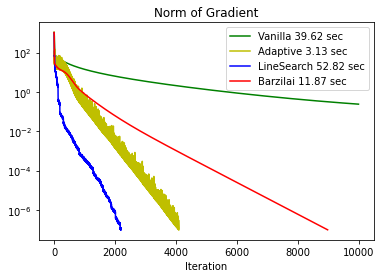

epsilon = 1e-08 , 
allowed time = 120  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 142527 :
weights vector is: [ 0.32394582 -0.81957915  9.33731087 -0.94536276 -4.4096518  -1.17070212
 -0.5095271   0.28210048  0.21061553 -0.41358659  0.0737342  -0.34127658
 -4.42248286  0.29648172 -0.22703396 -0.6219183   0.02618638  4.73226697
 -0.95377657 -0.96159299  0.12292927]
Gradient Norm is: 3.934891910386502e-07
Time taken: 60.0
Final Lambda value:  0.00018317812121041726
Percentage of points correctly classified:  83.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 5584 :
weights vector is: [ 0.32394639 -0.81957928  9.33731106 -0.94536283 -4.40965167 -1.17070221
 -0.50952713  0.2821004   0.21061544 -0.41358665  0.07373412 -0.34127669
 -4.4224827   0.29648167 -0.22703403 -0.62191843  0.02618631  4.73226673
 

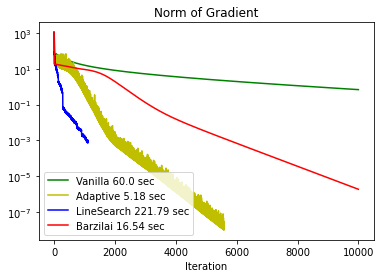

epsilon = 1e-09 , 
allowed time = 135  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 142090 :
weights vector is: [-11.6191286   13.5446213   11.51463675   0.57109249  -0.19468365
  -1.89451208  -0.7994995    1.91573943  -0.10261015  -0.54278377
   0.09937772  -0.74344996   0.46672882  -0.31698625  -1.29932272
   7.06242828   0.41315479  -0.15769005  -2.33817524  -0.29935853
   0.31374518]
Gradient Norm is: 0.012641107173934202
Time taken: 60.0
Final Lambda value:  0.00018369785804730565
Percentage of points correctly classified:  86.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 9437 :
weights vector is: [-11.67683105  13.5626556   11.52631912   0.57559858  -0.18731749
  -1.8948142   -0.79276661   1.91990993  -0.09750407  -0.53867209
   0.10360047  -0.73892584   0.47438196  -0.31360364  -1.29556972
 

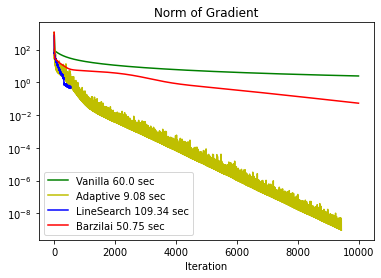

In [19]:
for i in range(1,10):
    G = logRegGD(10**(-i) , 30, 10**4)
    G.generate(1000, 0.1)
    print("epsilon =", 10**(-i), ", \nallowed time =", 60, " seconds")
    print("##_____________________________________________________________________##")
    G.Vanilla()
    G.Adaptive()
    G.LineSearch()
    G.Barzilai()
    G.PrintPlots()

Five iterations, logarithmic scale

epsilon = 0.1 , 
allowed time = 15  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 39418 :
weights vector is: [-15.47866434  -0.08327419  12.97120425   0.18517643  -0.65840735
   0.97928547  -0.40586421   0.25878919   1.31619643   0.21993512
   0.14584561  -0.04435746  -0.07392422  -0.77997806   0.5077678
  -1.01706889   2.7130574    0.18079599   2.958318    -2.23937093
  13.28268529]
Gradient Norm is: 0.9296334575431787
Time taken: 15.0
Final Lambda value:  0.00017585084236340878
Percentage of points correctly classified:  87.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 3505 :
weights vector is: [-20.63800541   0.24780854  15.38810447   0.69493623  -0.51344031
   1.57229538   0.19281497   0.65084395   1.56522192   0.65659198
   0.21544402   0.22851002   0.44551385  -0.59818002   1.04751945
  -1.01359338   2.91531929   0.70981089   2.37422534  -2.04234437
  15.70766247]
Gradient Norm is: 0.09973175434652759
Time taken: 2.7
Final Lambda value:  0.0031225504167791207
Percentage of points correctly classified:  87.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 557 :
weights vector is: [-17.01622391   0.02027234  13.66107056   0.34883767  -0.60881913
   1.1724238   -0.21112981   0.37622408   1.39325503   0.352607
   0.16810085   0.04274225   0.07928378  -0.72083267   0.67236323
  -1.01442849   2.75636369   0.34349015   2.76653393  -2.16178969
  13.97492745]
Gradient Norm is: 0.668788705492041
Time taken

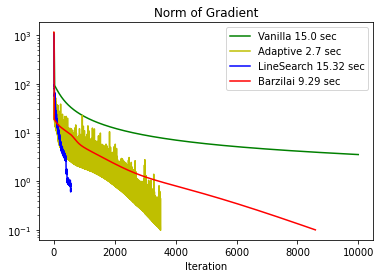

epsilon = 0.01 , 
allowed time = 30  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 61701 :
weights vector is: [-3.72151625  0.41808347  0.68540925 -0.76494779 17.30983889 -0.02552924
 -0.63796743  0.26682967 -0.67220449  3.96821422 -0.38613223 -5.30778612
  1.16500245  0.42280368 -0.58489062 -0.4925009  -2.0459384   0.20403246
 -0.63865925 -2.88892682 -0.22048274]
Gradient Norm is: 0.009999767993436335
Time taken: 23.08
Final Lambda value:  0.000199079619862159
Percentage of points correctly classified:  90.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2270 :
weights vector is: [-3.74572642  0.42556239  0.69480804 -0.76147031 17.33146063 -0.02252939
 -0.63463123  0.2752152  -0.67092134  3.96649998 -0.38317208 -5.32287251
  1.16788934  0.42833027 -0.58242432 -0.49142934 -2.0443705   0.21181303
 -0.63

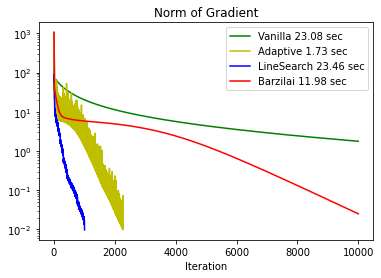

epsilon = 0.001 , 
allowed time = 45  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 116996 :
weights vector is: [-9.32750889 -0.07784469  0.49576113  0.57856713  5.86055605 -0.74868675
  1.01929957 -0.38811366  0.57790274  0.16705814  5.26545192  1.2266124
  0.97443626 -0.58516387  5.81079693 -0.26388519 -0.87834483  0.95537392
 -1.02518938 -0.7905964  -0.17437301]
Gradient Norm is: 0.0009999567392222767
Time taken: 43.18
Final Lambda value:  0.00017688540345140588
Percentage of points correctly classified:  84.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4208 :
weights vector is: [-9.33221964 -0.07744727  0.49619533  0.57908352  5.8610132  -0.74839205
  1.01981973 -0.38771105  0.57853327  0.16747672  5.26602116  1.22726802
  0.97503303 -0.58478754  5.81110566 -0.2635889  -0.87788317  0.95589206
 -

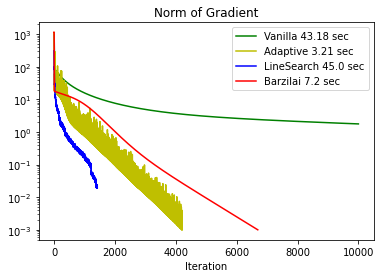

epsilon = 0.0001 , 
allowed time = 60  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 113154 :
weights vector is: [ -2.03577745  -0.63811338   5.66947805   1.53360247   0.15746489
   0.52214458   0.2894102   -0.86361159  12.0094521   -0.70743476
   0.16924969  -0.31046751   1.36075577  -1.29659145  -0.70678508
  -0.03683104  -1.08811658 -11.75982634   1.19277956  -0.60973381
   0.3320069 ]
Gradient Norm is: 9.999270320336075e-05
Time taken: 41.75
Final Lambda value:  0.00016986641522217684
Percentage of points correctly classified:  90.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 3266 :
weights vector is: [ -2.03595116  -0.63807326   5.66949434   1.53363857   0.15751598
   0.5221949    0.28947445  -0.86358957  12.00953814  -0.70741899
   0.16927847  -0.31045539   1.36082416  -1.29672122  -0.70675517

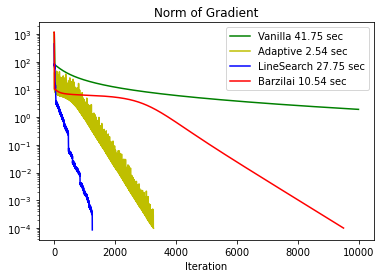

epsilon = 1e-05 , 
allowed time = 75  seconds
##_____________________________________________________________________##
 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 200828 :
weights vector is: [  3.30032061 -12.73329831  -0.57589108  -0.62710692  -0.60685032
   0.79963442  -4.13305835  17.86072879  -2.09391071  -0.94568908
   0.69586548  -2.64681429   3.8090133   -0.13231121   0.66407593
   0.8064575    0.06929732   1.09047775  -2.29166489  -0.44463568
   0.93860003]
Gradient Norm is: 0.00036778078765789855
Time taken: 75.0
Final Lambda value:  0.00018863026250739672
Percentage of points correctly classified:  92.0 %

 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 4595 :
weights vector is: [  3.30100646 -12.73379859  -0.57601846  -0.62730864  -0.60705525
   0.79959992  -4.13309251  17.86197959  -2.09420151  -0.9458525
   0.69577456  -2.64708912   3.80942616  -0.13239685   0.66411821
 

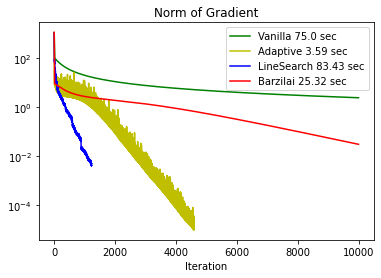

In [18]:
for i in range(1,6):
    G = logRegGD(10**(-i) , 15*i, 10**4)
    G.generate(1000, 0.1)
    print("epsilon =", 10**(-i), ", \nallowed time =", 15*i, " seconds")
    print("##_____________________________________________________________________##")
    G.Vanilla()
    G.Adaptive()
    G.LineSearch()
    G.Barzilai()
    G.PrintPlots()

One iterations, $ \epsilon < 10^{-1}$, 15 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 39190 :
weights vector is: [-11.3701796   16.9184937    0.49099119  -0.59191859   2.51388772
   0.50259873   0.34189022   0.3330157   -0.29125516  -0.71322257
   0.64256127  -1.08144477  -0.44533297   0.22530737   6.72544529
  -0.28854479  -3.11007145  -1.9577218    0.37949478  -0.25289226
  -0.7846777 ]
Gradient Norm is: 0.5832665136716818
Time taken: 15.0
Final Lambda value:  0.00017156150707073328
Percentage of points correctly classified:  86.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 1860 :
weights vector is: [-13.32902009  18.25364561   0.79221631  -0.44615027   2.18926056
   0.76970979   0.50453468   0.5659366   -0.14491914  -0.58928196
   0.87160198  -1.06791629  -0.31552764   0.43623467   7.28472097
  -0.20114224  -3.58384677  -1.90198509   0.56857185  -0.0497695
  -0.73553277]
Gradient Norm is: 0.09963918239142554
Time taken: 1.42
Final Lambda value:  0.002056616475093286
Percentage of points correctly classified:  86.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 430 :
weights vector is: [-8.12214827e+00  1.47978662e+01  5.67075210e-04 -8.63437436e-01
  3.10301816e+00  2.43516317e-02  6.32384518e-02 -4.81690234e-02
 -5.52086872e-01 -9.31389730e-01  2.63827014e-01 -1.13406192e+00
 -6.65889332e-01 -1.36880697e-01  5.82868587e+00 -4.54561706e-01
 -2.33238442e+00 -2.05335751e+00  5.27177612e-02 -5.91781945e-01

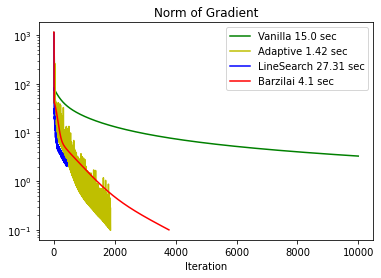

In [8]:
G = logRegGD(1e-1 , 15, 10**4)
G.generate(1000, 0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()

One iterations, $ \epsilon < 10^{-3}$, 30 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 55898 :
weights vector is: [ 0.12631504  0.28183504 -0.29590043  0.13932289  0.01429148 -0.75359316
  9.70533871 -0.22306131 -1.89709645 -0.51043889 -0.49216203  1.43630777
 -0.16615346  0.01146049  2.88039775 -0.10064947  0.10486361  1.09572151
  0.78372323 -0.43912157 -8.86465064]
Gradient Norm is: 0.00099992813477454
Time taken: 21.09
Final Lambda value:  0.0001793827663310195
Percentage of points correctly classified:  93.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 2002 :
weights vector is: [ 0.12818569  0.28137949 -0.29663996  0.13887494  0.01386505 -0.75388477
  9.70638643 -0.22399566 -1.89751222 -0.51071654 -0.49273699  1.43576672
 -0.16488508  0.0107127   2.88114754 -0.10116498  0.10447387  1.09532684
  0.78354662 -0.43964762 -8.86377164]
Gradient Norm is: 0.000994738282438878
Time taken: 1.55
Final Lambda value:  0.0020016699957994023
Percentage of points correctly classified:  93.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 816 :
weights vector is: [ 0.1264446   0.28180406 -0.29594853  0.13929004  0.01426378 -0.75361648
  9.70543879 -0.22313    -1.89714036 -0.51046232 -0.49220924  1.43628455
 -0.16606862  0.01141115  2.88045873 -0.10068682  0.10483597  1.09570411
  0.78371766 -0.43916168 -8.86461449]
Gradient Norm is: 0.0008739007466365868
Time taken: 18.19
Final Lambda value:  0.00177

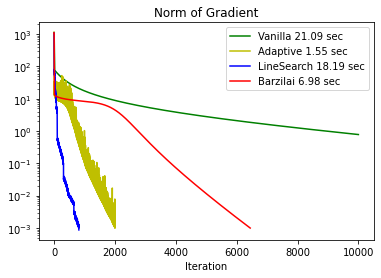

In [6]:
G = logRegGD(1e-3 , 30, 10**4)
G.generate(1000, 0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()

One iterations, $ \epsilon < 10^{-6}$, 60 seconds allowed per method

 
 Vanilla Gradient Descent:
_____________________________________________
At final iteration k = 164040 :
weights vector is: [-1.59926765e+01 -9.97314385e-01 -5.98851396e-01  1.44763622e+00
 -8.12062011e-02  6.73154351e-01 -5.47256403e-01  1.66570914e+01
  1.12132665e+00  4.71680790e+00 -9.90048943e-02 -1.20520221e+01
  2.99490621e-01  9.81301405e-02  8.81485654e-02 -2.19672620e-01
 -4.70798029e-01  2.65720530e+00  4.36148790e-01  2.55759699e+01
  2.15136486e-02]
Gradient Norm is: 0.05504849255050246
Time taken: 60.0
Final Lambda value:  0.00018973892080890458
Percentage of points correctly classified:  90.0 %


<ipython-input-5-71fbc014ab1b>:27: RuntimeWarning: overflow encountered in exp
  def sigmoid(self, beta, X): return 1.0/(1 + np.exp(-np.dot(X, beta))) # sigmoid function



 Adaptive Gradient Descent:
_____________________________________________
At final iteration k = 12561 :
weights vector is: [-16.26932173  -1.01187947  -0.61032088   1.48558102  -0.06084642
   0.69534958  -0.54969767  16.86681822   1.15656571   4.75795893
  -0.08098138 -12.2509196    0.31773433   0.11586477   0.09731235
  -0.20213984  -0.46803852   2.71701533   0.45521177  25.92930351
   0.03579833]
Gradient Norm is: 9.992183014771204e-07
Time taken: 9.62
Final Lambda value:  0.005300012835674103
Percentage of points correctly classified:  90.0 %

 Line Search Gradient Descent:
_____________________________________________
At final iteration k = 2323 :
weights vector is: [-16.17735896  -1.00694844  -0.60643096   1.47294491  -0.06759888
   0.68799235  -0.5488333   16.79680403   1.14483469   4.74405596
  -0.08694626 -12.18469738   0.31172129   0.10999016   0.09431242
  -0.20794432  -0.46890947   2.69719113   0.44887926  25.81140164
   0.03108517]
Gradient Norm is: 0.02000869137557162
Ti

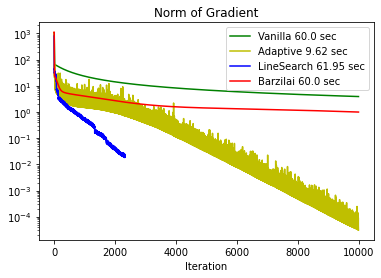

In [7]:
G = logRegGD(1e-6 , 60, 10**4)
G.generate(1000,0.1)
G.Vanilla()
G.Adaptive()
G.LineSearch()
G.Barzilai()
G.PrintPlots()